In [2]:
"""
Purpose of notebook: 1: read a grd file and plot it using GMT
                     2: subsample the grid and save to csv
                     3: plot the subsampled points using GMT
                     
Requirements: gmt, geopy, pandas
"""

#########################################################################
# define filename and use gmt grdinfo to display information about grid #
#########################################################################

FILENAME = 'threesis_19950924_20010902.grd'
# ! indicates a shell command, -La scans the date to report real z stats
! gmt grdinfo $FILENAME -La

grdinfo [WARNING]: 2971229 Multiple modes found in the grid
threesis_19950924_20010902.grd: Title: ERS2 Rangechange Interferogram stack, 19950924-20010902
threesis_19950924_20010902.grd: Command: xyz2grd -V -R-122.60/-120.4008333333/42.9/45.09916667 -I3c/3c tmp.xyz -Grng_avg_9.grd -Ddd/dd/mm/1/=/Demeaned Range Change
threesis_19950924_20010902.grd: Remark: WGS84, 20.5 deg incidence angle, 192.7 deg Az satellite heading, nodata=-9999
threesis_19950924_20010902.grd: Gridline node registration used [Cartesian grid]
threesis_19950924_20010902.grd: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
threesis_19950924_20010902.grd: x_min: -122.600000002 x_max: -120.400833335 x_inc: 0.000833333333346 name: deg n_columns: 2640
threesis_19950924_20010902.grd: y_min: 42.9 y_max: 45.09916667 y_inc: 0.000833333334596 name: deg n_rows: 2640
threesis_19950924_20010902.grd: z_min: -9999 z_max: 29.9956474304 name: mm
threesis_19950924_20010902.grd: scale_factor: 1 add_offset: 0
threesis_19

In [20]:
#######################################
# make a color plot to visualize data #
#######################################

# use automatic=True to find the bounds of the region from the grid file,
# or use automatic=False to supply different bounds to plot 
automatic = False

if automatic:
    # first store the region that the grid file encompasses as variables to pass to GMT
    XMIN = ! gmt grdinfo $FILENAME -Cn -o0
    XMAX = ! gmt grdinfo $FILENAME -Cn -o1
    YMIN = ! gmt grdinfo $FILENAME -Cn -o2
    YMAX = ! gmt grdinfo $FILENAME -Cn -o3
    # the above gmt grdinfo command stores the values in a list. we only want the string
    XMIN = XMIN[0]
    XMAX = XMAX[0]
    YMIN = YMIN[0]
    YMAX = YMAX[0]
else:
    # define bounds to plot
    XMIN = -122.1
    XMAX = -121.4
    YMIN = 43.7
    YMAX = 44.5

# feed the data to gmt, write to color_grid.png
! gmt begin color_grid png

    # create the map frame and set the region and projection
!    gmt basemap -R$XMIN/$XMAX/$YMIN/$YMAX -JM15c -Baf

    # plot topography using gmt built-in dataset at the highest resolution
!    gmt grdimage @earth_relief_01s -Cgray -I+d

    # make a new colormap that only covers the values of interest for the grid
!    gmt makecpt -Cseis -T-140/35

    # plot grid as colored map using grdimage, transparency 60%
!    gmt grdimage $FILENAME -t60 -Q

    # show the colorbar, ticks every 25 mm, add title
!    gmt colorbar -B25 -Bx+l"range change [mm]"

! gmt end show

grdblend [WARNING]: File @N40W130.earth_relief_15s_p.nc has different increments (0.00416666666667/0.00416666666667) than the output grid (0.000277777777778/0.000277777777778) - must resample
grdblend [WARNING]: File @N40W130.earth_relief_15s_p.nc coordinates are phase-shifted w.r.t. the output grid - must resample


,longitude,latitude,displacement
0,-122.100000,44.5,-9999.0
1,-122.099167,44.5,-9999.0
2,-122.098333,44.5,-9999.0
3,-122.097500,44.5,-9999.0
4,-122.096667,44.5,-9999.0


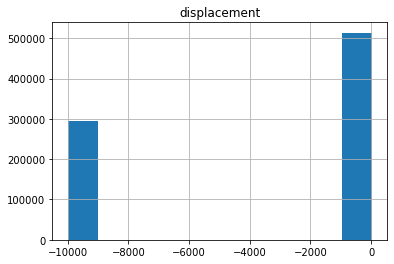

In [28]:
########################################
# subsample the grid file to 100 points #
########################################
"""
# for a simply regridding use gmt to resample the grid as below:
# define output file name
OUTFILE = 'resampled.grd'
# resample using grdsample, -I denotes number of nodes, -R denotes subregion, 
! gmt grdsample $FILENAME -I0.02 -R$XMIN/$XMAX/$YMIN/$YMAX -G$OUTFILE
# inspect the details of the new file
! gmt grdinfo $OUTFILE -La
"""
import pandas as pd

# define region of interest to subsample
XMIN = -122.1
XMAX = -121.4
YMIN = 43.7
YMAX = 44.5

# write subregion of grd file to text to sample the grid pythonically 
#! gmt grd2xyz $FILENAME -R$XMIN/$XMAX/$YMIN/$YMAX > grid.xyz

# load the xyz file into a pandas dataframe
df = pd.read_table("grid.xyz", header=None, names=['longitude', 'latitude', 'displacement'])

# look at a histogram of the displacement column
df.hist(column='displacement')

# look at the first several lines of the data
df.head()

,longitude,latitude,displacement
108,-122.010000,44.5,-3.414200
109,-122.009167,44.5,-1.437483
110,-122.008333,44.5,6.218685
111,-122.007500,44.5,-2.747391
112,-122.006667,44.5,-5.116592


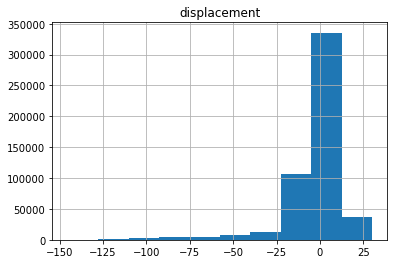

In [29]:
# from looking at the data we can see that the value -9999.0 is
# equivalent to missing data, so lets not consider those entries
df = df[df.displacement > -9999.0]

# look at the distribution again. it looks better this time
df.hist(column='displacement')
df.head()

In [30]:
# for this case I want to sample the grid more densely near the deformation source
from typing import List
from geopy import Point
from geopy.distance import distance
import numpy
from numpy.random import randint

# 2D location estimate
deformation_Source = [-121.835, 44.090]

# find all points within a 10 km radius from the deformation source using a function
def ellipsoidal_Distance(point1: List[float], point2: List[float]) -> float:
    """Returns the distance between two points on Earth.

    Inputs (in decimal degrees):
            point1: list[longitude, latitude]
            point2: list[longitude, latitude]
    """
    longitude1, latitude1 = point1
    longitude2, latitude2 = point2
    point1_object = Point(latitude1, longitude1)
    point2_object = Point(latitude2, longitude2)
    distance_2D = distance(point1_object, point2_object).km
    return abs(distance_2D)

# loop through df rows and record the distance from each point to the source
distance_From_Source_List = []
for row in range(len(df)):
    distance_From_Source = ellipsoidal_Distance([df.iloc[row , 0], df.iloc[row , 1]], deformation_Source)
    distance_From_Source_List.append(distance_From_Source)

# append list to df as new column
df['distance_from_source'] = distance_From_Source_List

# save data within and outside 10km as new dataframes
within_10km_df = df[df.distance_from_source <= 10.0]
outside_10km_df = df[df.distance_from_source > 10.0]

# generate 40 pseudorandom indices to sample from each subset
random.seed(91) # set seed for reproducibility
within_Indices = randint(len(within_10km_df), size=40)
outside_Indices = randint(len(outside_10km_df), size=60)
within_10km_df = within_10km_df.iloc[within_Indices, [0, 1, 2]]
outside_10km_df = outside_10km_df.iloc[outside_Indices, [0, 1, 2]]

# print the contents to verify they aren't garbage
print("Within 10 km subset:")
print(within_10km_df)
print("\nOutside 10 km subset:")
print(outside_10km_df)

# merge the dataframes to save to a single file
result = pd.concat([within_10km_df, outside_10km_df])
# shuffle the rows of the dataframe
result = result.sample(frac=1).reset_index(drop=True)
# save subsets combined as one csv file
result.to_csv("sisters.csv", index=False, header=True)

Within 10 km subset:
         longitude   latitude  displacement
392368 -121.715000  44.111667    -16.353022
410727 -121.834167  44.093333   -128.765533
430100 -121.809167  44.074167    -95.653030
467120 -121.795833  44.037500    -38.249203
446978 -121.760833  44.057500    -28.109644
426793 -121.761667  44.077500    -41.004234
408183 -121.851667  44.095833   -120.855240
466191 -121.869167  44.038333    -41.354813
377064 -121.853333  44.126667    -79.384201
419119 -121.849167  44.085000   -108.368546
393021 -121.871667  44.110833    -83.057510
437616 -121.853333  44.066667    -89.086975
408148 -121.880833  44.095833    -82.838112
447782 -121.791667  44.056667    -56.743141
438486 -121.829167  44.065833    -95.764664
351927 -121.775833  44.151667    -26.765930
350203 -121.810833  44.153333    -45.785145
387295 -121.737500  44.116667    -31.182356
440164 -121.832500  44.064167    -93.929672
364409 -121.886667  44.139167    -36.715561
414220 -121.726667  44.090000    -19.833158
387089 -121

In [31]:
################################
# plot the subsampled csv file #
################################

# feed the data to gmt, write to resampled_grid.png
! gmt begin resampled_grid png

    # create the map frame and set the region and projection
!    gmt basemap -R$XMIN/$XMAX/$YMIN/$YMAX -JM15c -Baf

    # plot topography using gmt built-in dataset at the highest resolution
!    gmt grdimage @earth_relief_01s -Cgray -I+d

    # make a new colormap that only covers the values of interest for the grid
!    gmt makecpt -Cseis -T-140/35

    # plot points colored by displacement (mm)
!    gmt plot sisters.csv -Sc0.3c -C

    # show the colorbar, ticks every 25 mm, add title
!    gmt colorbar -B25 -Bx+l"range change [mm]"

#     # to plot a fake point source 
# !    echo -121.835 44.090 > t.dat
# !    gmt plot t.dat -Gblack -Sc0.5c

! gmt end show

grdblend [WARNING]: File @N40W130.earth_relief_15s_p.nc has different increments (0.00416666666667/0.00416666666667) than the output grid (0.000277777777778/0.000277777777778) - must resample
grdblend [WARNING]: File @N40W130.earth_relief_15s_p.nc coordinates are phase-shifted w.r.t. the output grid - must resample
